In [2]:
import pandas as pd
df_ml = pd.read_csv("../data/processed/ML_Chile_2022-12-27.csv")
df_ml.dropna(subset=["tweet_text"], inplace=True)
# df_f = pd.read_csv("../data/processed/FalabellaAyuda_2022-12-27.csv")
# df_r = pd.read_csv("../data/processed/RipleyChile_2022-12-27.csv")
# df_p = pd.read_csv("../data/processed/tiendas_paris_2022-12-27.csv")

In [3]:
def df_to_list(df):
    texts = df["tweet_text"]
    data = []
    for text in texts:
        data.append(text)
    return data

In [4]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from src import Features
inputs = df_to_list(df_ml)
inputs = Features.bert_encoder(inputs, tokenizer_español)
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
data_ml = {
        "max_polling_std": Features.std_normalization(Features.max_polling(last_hidden_states)),
        "max_polling_z_score": Features.z_score_normalization(Features.max_polling(last_hidden_states)),
        "max_polling_max": Features.max_min_normalization(Features.max_polling(last_hidden_states)),
        "mean_polling_std": Features.std_normalization(Features.mean_polling(last_hidden_states)),
        "mean_polling_z_score": Features.z_score_normalization(Features.mean_polling(last_hidden_states)),
        "mean_polling_max": Features.max_min_normalization(Features.mean_polling(last_hidden_states)),
    }

In [6]:
def find_indexs(list, value):
    list_aux = list.copy()
    output = []
    while True:
        try:
            index = list_aux.index(value)
            output.append(index)
            list_aux[index] = None
        except ValueError:
            break
    return output

# agrupamiento

# Metricas de evaluacion de clustering

In [7]:
def cluster_variance(X, cluster_labels, centers, k):
    distance = lambda point0, point1: np.linalg.norm(point1 - point0)
    puntos = X[cluster_labels == k]
    c = centers[k]
    distancias = [distance(i, c) for i in puntos]
    N = len(puntos)
    mean = sum(distancias)/N
    with np.errstate(all='raise'):
        #sum([(i-mean)**2 for i in distancias])/ (N - 1)
        try:
            variance = sum([(i-mean)**2 for i in distancias])/ (N - 1)
        except FloatingPointError:
            variance = distancias[0]
    return variance

In [8]:
def decimal_scaling_normalization(vector):
    i = 0
    while True:
        vector_normalized = vector/ (10**i)
        i += 1
        if vector_normalized.max() < 1.0:
            break
    return vector_normalized

# k-means

In [9]:
# k-means
from sklearn.cluster import KMeans
from sklearn import metrics
agrupamiento = {}
VP_by_k_centroids = []
silhouettes_by_k_centroids = []
for K in range(2, 8):
    si = []
    vp = []
    for key, value in data_ml.items():
        # value shape: (77, 768)
        value = np.array(value)
        kmeans = KMeans(
            n_clusters=K,
            init="random",
            max_iter=100,
            random_state=1,
            n_init=1,
        )
        cluster_labels = kmeans.fit_predict(value)
        centers = kmeans.cluster_centers_
        agrupamiento[key] = list(cluster_labels)
        si.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        variances = []
        for k in range(K):
            variance = cluster_variance(value, cluster_labels, centers, k)
            variances.append(variance)
        avg_variance = sum(variances)/len(variances)
        vp.append(avg_variance)
    silhouettes_by_k_centroids.append(si)
    VP_by_k_centroids.append(vp)

    #print(f"{round(metrica[0], 3)} {round(metrica[1], 3)} {round(metrica[2], 3)} {round(metrica[3], 3)} {round(metrica[4], 3)} {round(metrica[5], 3)}")
print(silhouettes_by_k_centroids)
print(VP_by_k_centroids)

[[0.5952886290914435, 0.05169099673140693, 0.6070510159238747, 0.16791651691019827, 0.1732579740348624, 0.44526564824259623], [0.4675132173954347, 0.1454570359334612, 0.5338310749891785, 0.2392685951110199, 0.23770629365065402, 0.26925124078467233], [0.4668426054332192, 0.11065410740229353, 0.5324243158394212, 0.2010876004707764, 0.17185469978372528, 0.25151251380910733], [0.03988354768479275, 0.028881452758149413, 0.4277657524781795, 0.1703808725711446, 0.08316485318377682, 0.22533340664462448], [-0.11866392101949019, 0.0024065015997855868, 0.3071643663138237, 0.12491929352067777, 0.07772468629006288, 0.1445326481836347], [-0.13219406844483797, -0.0032061248533308364, 0.23998951113171785, 0.03396616658186825, 0.025965653287473474, 0.0969039884009535]]
[[4.005555151407097e-06, 2.21402404269986, 0.11353626462547617, 1.2840891953524692e-05, 0.9987087668911016, 0.002222761051745857], [6.8759224436867225e-06, 1.811883071629121, 0.04709088991311395, 1.2315969207136117e-05, 1.109695372878712

In [10]:
def ordenar(vector0, vector1):
    silhouettes_by_k_centroids = vector0.copy()
    VP_by_k_centroids = vector1.copy()
    si = []
    vp = []
    for i in range(6):
        m_s = []
        m_vp = []
        for sI, vP in zip(silhouettes_by_k_centroids, VP_by_k_centroids):
            m_s.append(sI[i])
            m_vp.append(vP[i])
        si.append(m_s)
        vp.append(m_vp)
    return si, vp

silhouettes_by_k_centroids, VP_by_k_centroids = ordenar(silhouettes_by_k_centroids,
                                                        VP_by_k_centroids)
print(silhouettes_by_k_centroids)
print(VP_by_k_centroids)


[[0.5952886290914435, 0.4675132173954347, 0.4668426054332192, 0.03988354768479275, -0.11866392101949019, -0.13219406844483797], [0.05169099673140693, 0.1454570359334612, 0.11065410740229353, 0.028881452758149413, 0.0024065015997855868, -0.0032061248533308364], [0.6070510159238747, 0.5338310749891785, 0.5324243158394212, 0.4277657524781795, 0.3071643663138237, 0.23998951113171785], [0.16791651691019827, 0.2392685951110199, 0.2010876004707764, 0.1703808725711446, 0.12491929352067777, 0.03396616658186825], [0.1732579740348624, 0.23770629365065402, 0.17185469978372528, 0.08316485318377682, 0.07772468629006288, 0.025965653287473474], [0.44526564824259623, 0.26925124078467233, 0.25151251380910733, 0.22533340664462448, 0.1445326481836347, 0.0969039884009535]]
[[4.005555151407097e-06, 6.8759224436867225e-06, 5.068370699822731e-06, 4.056480058973074e-06, 3.3815770557856542e-06, 3.1758731842965916e-06], [2.21402404269986, 1.811883071629121, 1.4639314034848658, 1.2885960330349395, 1.0792611407504

# Visualización de los resultados de la metricas para encontrar el k-óptimo.

In [11]:
def optimo_k(silhouettes, VP):
    distance = np.array(silhouettes) - np.array(VP)
    index = np.argmax(distance)
    return index

In [12]:
# escalado de VP
def decimal_scaling_normalization(vector):
    i = 0
    while True:
        vector_normalized = vector/ (10**i)
        i += 1
        if vector_normalized.max() < 1.0:
            break
    return vector_normalized

In [13]:
x = range(2, 8)

In [14]:
print(silhouettes_by_k_centroids[1], VP_by_k_centroids[1])
np.array(silhouettes_by_k_centroids[1]) - np.array(VP_by_k_centroids[1])

[0.05169099673140693, 0.1454570359334612, 0.11065410740229353, 0.028881452758149413, 0.0024065015997855868, -0.0032061248533308364] [2.21402404269986, 1.811883071629121, 1.4639314034848658, 1.2885960330349395, 1.0792611407504478, 0.8357684227257227]


array([-2.16233305, -1.66642604, -1.3532773 , -1.25971458, -1.07685464,
       -0.83897455])

optimo: 0 , x(optimo): 2, y(optimo): 0.5952886290914435
optimo: 1 , x(optimo): 3, y(optimo): 0.1454570359334612
optimo: 2 , x(optimo): 4, y(optimo): 0.5324243158394212
optimo: 1 , x(optimo): 3, y(optimo): 0.2392685951110199
optimo: 1 , x(optimo): 3, y(optimo): 0.23770629365065402
optimo: 0 , x(optimo): 2, y(optimo): 0.44526564824259623


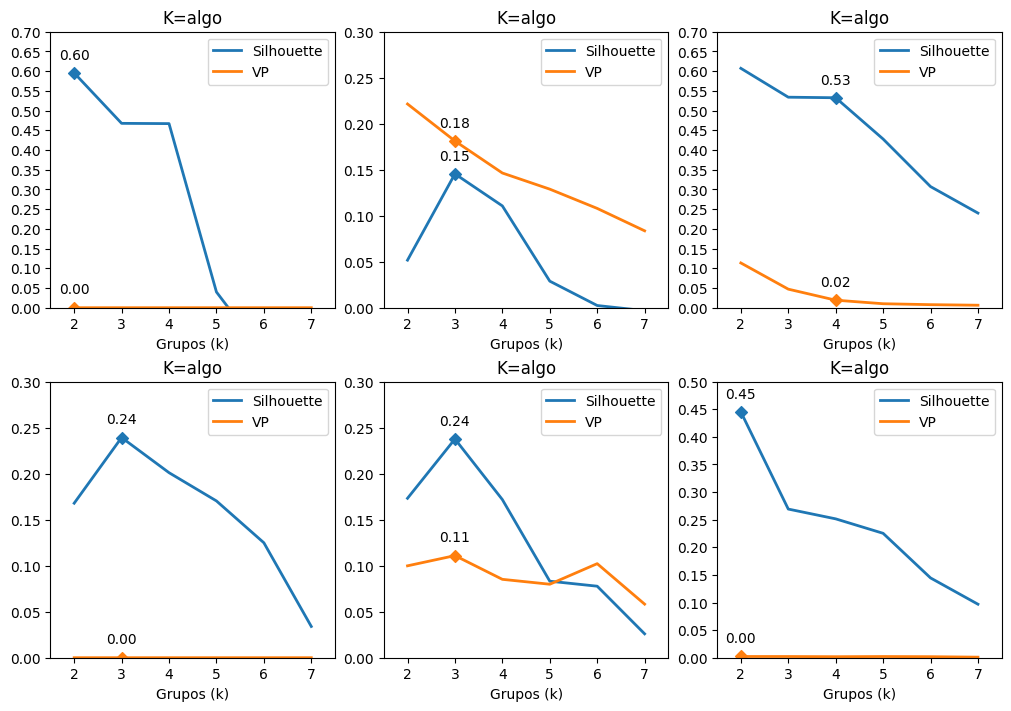

In [15]:
import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')
k_optimos = []
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7),
                        layout="constrained")
for ax, sI, vP in zip(axs.flat, silhouettes_by_k_centroids, VP_by_k_centroids):
    vP = decimal_scaling_normalization(np.array(vP))
    optimo = optimo_k(sI, vP)
    k_optimos.append(optimo)
    print(f"optimo: {optimo} , x(optimo): {x[optimo]}, y(optimo): {sI[optimo]}")
    # plot

    ax.plot(x, sI, linewidth=2.0, label="Silhouette")
    ax.plot(x, vP, linewidth=2.0, label="VP")
    ax.scatter([x[optimo]], [sI[optimo]], marker="D")
    ax.scatter(x[optimo], vP[optimo], marker="D")
    y_max_lim = max([max(vP), max(sI)])
    y_max_lim = round(y_max_lim, 1) + 0.1
    ax.set(xlim=(x[0] - 0.5, x[-1] + 0.5), xticks=np.arange(x[0], x[-1] + 1),
        ylim=(0, y_max_lim), yticks=np.arange(0, y_max_lim + 0.05, 0.05))
    ax.set_xlabel("Grupos (k)")

    label0 = "{:.2f}".format(sI[optimo])
    ax.annotate(label0,
                (x[optimo],sI[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    label1 = "{:.2f}".format(vP[optimo])
    ax.annotate(label1,
                (x[optimo],vP[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax.set_title(f"K=algo")
    ax.legend()
k_optimos = np.array(k_optimos) + 2

plt.show()

# visualización de resultados de analisis de sentimiento en los grupos creados

In [16]:
k_optimos

array([2, 3, 4, 3, 3, 2])

In [17]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=k_optimos[i],
        init="random",
        max_iter=100,
        random_state=1,
        n_init=1,
    ).fit(value)
    agrupamiento[key] = [list(kmeans.labels_), k_optimos[i]]
    i += 1

clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {}
    for k in range(value[1]):
        clusters[key][f"grupo {k + 1}"] = df_ml.iloc[find_indexs(agrupamiento[key][0], k)]

# preprocesado vs sentimiento.
sentiment_analysis = {}
i=0
for kesI, value0 in clusters.items():
    sentiment_analysis[kesI] = {}
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment_analysis[kesI][kevP] = {f"{label}": value for label, value in zip(sentiment_labels, sentiment_values)}

sentiment_analysis


{'max_polling_std': {'grupo 1': {'others': 5, 'sadness': 2, 'joy': 1},
  'grupo 2': {'others': 44, 'anger': 16, 'sadness': 9}},
 'max_polling_z_score': {'grupo 1': {'others': 7,
   'anger': 4,
   'sadness': 2,
   'joy': 1},
  'grupo 2': {'sadness': 4, 'others': 1},
  'grupo 3': {'others': 41, 'anger': 12, 'sadness': 5}},
 'max_polling_max': {'grupo 1': {'others': 2, 'anger': 1, 'joy': 1},
  'grupo 2': {'others': 6, 'sadness': 5},
  'grupo 3': {'others': 19, 'anger': 10, 'sadness': 2},
  'grupo 4': {'others': 22, 'anger': 5, 'sadness': 4}},
 'mean_polling_std': {'grupo 1': {'others': 10,
   'anger': 5,
   'sadness': 2,
   'joy': 1},
  'grupo 2': {'sadness': 4, 'others': 1},
  'grupo 3': {'others': 38, 'anger': 11, 'sadness': 5}},
 'mean_polling_z_score': {'grupo 1': {'others': 11,
   'anger': 6,
   'sadness': 2,
   'joy': 1},
  'grupo 2': {'sadness': 4, 'others': 1},
  'grupo 3': {'others': 37, 'anger': 10, 'sadness': 5}},
 'mean_polling_max': {'grupo 1': {'others': 40, 'anger': 15, 'sa

In [18]:
lst = [[1,2,3], [3,3]]
def colours(lst):
    outer = []
    inner = []
    outer_colours = [0, 2, 4, 8]
    inner_colours = range(16)
    i0 = 0
    i1 = 0
    for l in lst:
        outer.append(outer_colours[i0])
        for e in l:
            inner.append(inner_colours[i1])
            i1 += 1
        i0 += 1
        i1 = i0 * 4
    return outer, inner
colours(lst)

([0, 2], [0, 1, 2, 4, 5])

In [19]:
def list_flatten(lst):
    outputs = []
    for l in lst:
        for e in l:
            outputs.append(e)
    return outputs

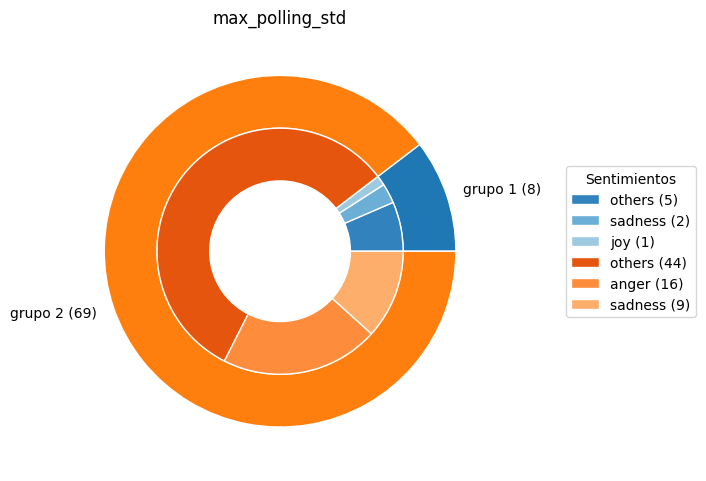

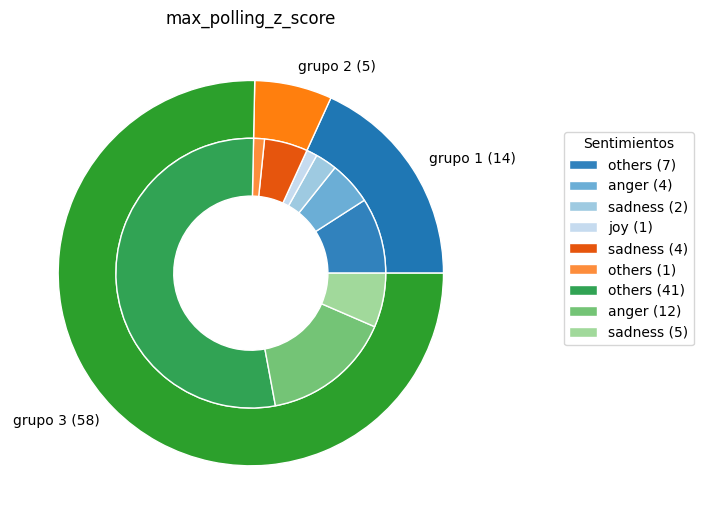

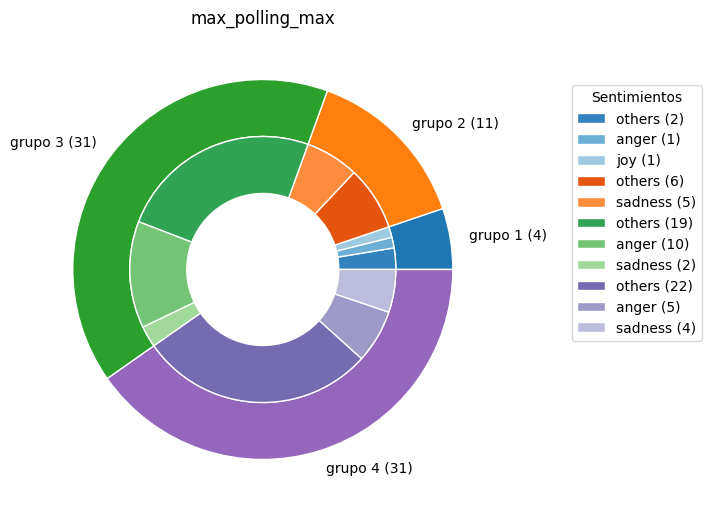

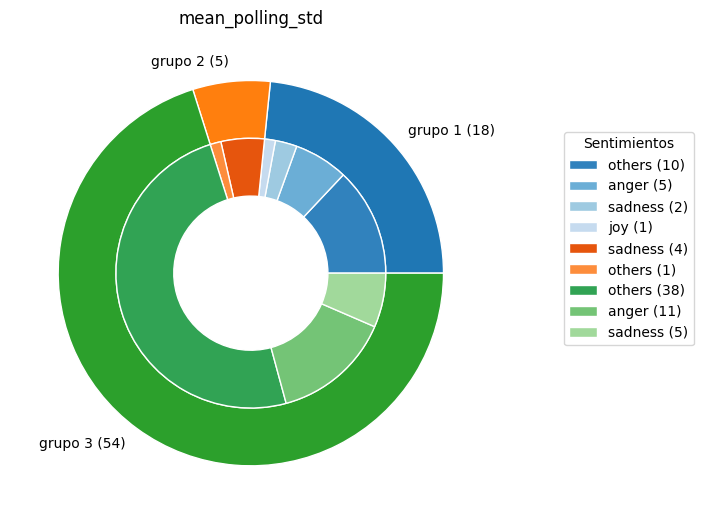

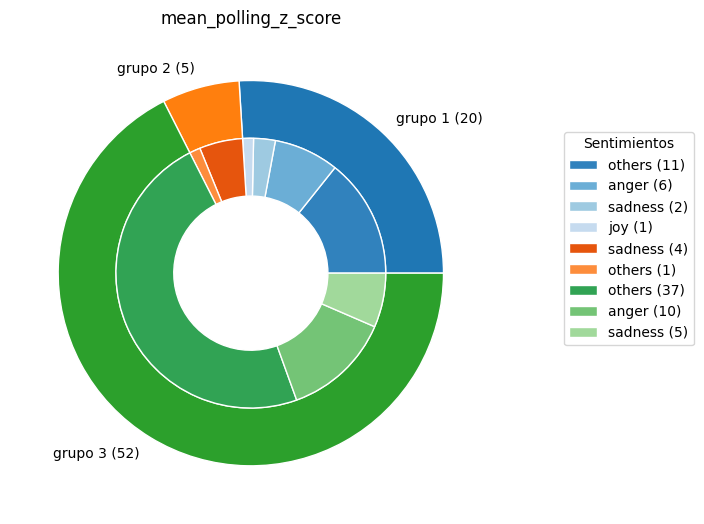

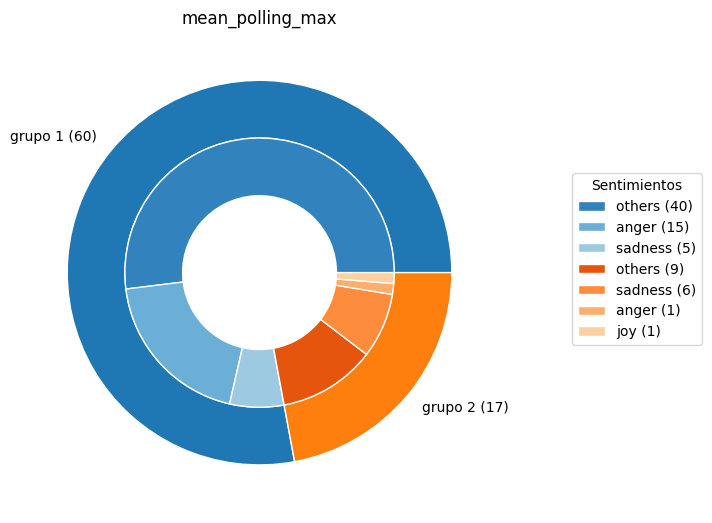

In [38]:
for key in sentiment_analysis.keys():
       fig, ax = plt.subplots(figsize=(7, 6),
                        layout="constrained")
       size = 0.3
       clusters_names = sentiment_analysis[key].keys()
       clusters_sentiments = [list(sentiment_analysis[key][c].keys()) for c in clusters_names]
       clusters_sentiments = list_flatten(clusters_sentiments)
       vals = [list(sentiment_analysis[key][c].values()) for c in clusters_names]
       clusters_names = [f"{c} ({sum(v)})" for c, v in zip(clusters_names, vals)]
       clusters_sentiments = [f"{s} ({v})" for s, v in zip(clusters_sentiments, list_flatten(vals))]

       outer_cmap = plt.get_cmap("tab20")
       inner_cmap = plt.get_cmap("tab20c")
       outer_colors, inner_colors = colours(vals)
       outer_colors = outer_cmap(np.array(outer_colors))
       inner_colors = inner_cmap(np.array(inner_colors))

       sum_vals = [sum(list(i)) for i in vals]
       ax.pie(sum_vals, radius=1, colors=outer_colors, labels=clusters_names,
              wedgeprops=dict(width=size, edgecolor='w'))

       ax.pie(list_flatten(vals), radius=1-size, colors=inner_colors, labels=[" " for _ in clusters_sentiments],
              labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

       ax.set(aspect="equal", title=f'{key}')
       handles, labels = ax.get_legend_handles_labels()

       ax.legend(handles[len(clusters_names):], clusters_sentiments, loc=(1.15, 0.35), title="Sentimientos")

plt.show()

# k-means++

In [21]:
agrupamiento = {}
metric = []
for i in range(100):
    metrica = []
    for key, value in data_ml.items():
        kmeans = KMeans(
            n_clusters=4,
            init="k-means++",
            max_iter=100,
            random_state=i,
            n_init=1,
        ).fit(value)
        agrupamiento[key] = list(kmeans.labels_)
        metrica.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
    metric.append(metrica)
    #print(f"{round(metrica[0], 3)} {round(metrica[1], 3)} {round(metrica[2], 3)} {round(metrica[3], 3)} {round(metrica[4], 3)} {round(metrica[5], 3)}")
rs = []
for i in range(6):
    list_aux = []
    for metrica in metric:
        list_aux.append(metrica[i])
    max_ = max(list_aux)
    index = list_aux.index(max_)
    rs.append([index, round(max_, 3)])
rs


[[71, 0.627], [7, 0.107], [3, 0.532], [72, 0.223], [18, 0.229], [90, 0.264]]

In [22]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=4,
        init="k-means++",
        max_iter=100,
        random_state=rs[i][0],
        n_init=1,
    ).fit(value)
    agrupamiento[key] = list(kmeans.labels_)
    i += 1
clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {
    "cluster0": df_ml.iloc[find_indexs(agrupamiento[key], 0)],
    "cluster1": df_ml.iloc[find_indexs(agrupamiento[key], 1)],
    "cluster2": df_ml.iloc[find_indexs(agrupamiento[key], 2)],
    "cluster3": df_ml.iloc[find_indexs(agrupamiento[key], 3)],
}
# preprocesado vs sentimiento.
print("rs rsScore cluster 1 cluster 2 cluster 3 cluster 4")
i = 0
for kesI, value0 in clusters.items():
    data = []
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment = [f"{label} ({value})" for label, value in zip(sentiment_labels, sentiment_values)]
        data.append(sentiment)
    string = f"{rs[i][0]} & {rs[i][1]} & {data[0]} & {data[1]} & {data[2]} & {data[3]}"
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", "")
    print(string)
    i += 1

rs rsScore cluster 1 cluster 2 cluster 3 cluster 4
71 & 0.627 & joy (1), others (1) & others (47), anger (16), sadness (9) & others (1) & sadness (2)
7 & 0.107 & others (41), anger (13), sadness (5) & others (3), sadness (1) & sadness (4), others (1) & others (4), anger (3), sadness (1), joy (1)
3 & 0.532 & others (19), anger (10), sadness (2) & others (22), anger (5), sadness (4) & others (6), sadness (5) & others (2), anger (1), joy (1)
72 & 0.223 & sadness (5), others (2), joy (1) & others (4), anger (1) & others (38), anger (10), sadness (5) & others (5), anger (5), sadness (1)
18 & 0.229 & others (4), joy (1), anger (1) & others (40), anger (13), sadness (5) & others (3), anger (2), sadness (1) & sadness (5), others (2)
90 & 0.264 & others (22), anger (9), sadness (1) & others (3), sadness (1), joy (1) & sadness (6), others (3) & others (21), anger (7), sadness (3)


# fuzzy c-means

In [23]:
from fcmeans import FCM
agrupamiento = {}
metric = []

rs = []
for key, value in data_ml.items():
    data = np.array(value)
    fcm = FCM(n_clusters=4)
    fcm.fit(data)
    labels = fcm.predict(data)
    grupos = fcm.soft_predict(data)
    agrupamiento[key] = labels
    rs.append(round(metrics.silhouette_score(
        value, labels, metric="sqeuclidean"), 3))
    #print(f"{round(metrica[0], 3)} {round(metrica[1], 3)} {round(metrica[2], 3)} {round(metrica[3], 3)} {round(metrica[4], 3)} {round(metrica[5], 3)}")
rs


[0.256, 0.094, 0.429, 0.167, 0.174, 0.128]

In [24]:
clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {
    "cluster0": df_ml.iloc[find_indexs(list(agrupamiento[key]), 0)],
    "cluster1": df_ml.iloc[find_indexs(list(agrupamiento[key]), 1)],
    "cluster2": df_ml.iloc[find_indexs(list(agrupamiento[key]), 2)],
    "cluster3": df_ml.iloc[find_indexs(list(agrupamiento[key]), 3)],

}
# preprocesado vs sentimiento.
print("rsScore cluster 1 cluster 2 cluster 3 cluster 4")
i = 0
for kesI, value0 in clusters.items():
    data = []
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment = [f"{label} ({value})" for label, value in zip(sentiment_labels, sentiment_values)]
        data.append(sentiment)
    string = f"{rs[i]} & {data[0]} & {data[1]} & {data[2]} & {data[3]}"
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", "")
    print(string)
    i += 1

rsScore cluster 1 cluster 2 cluster 3 cluster 4
0.256 & others (16), sadness (6), anger (5), joy (1) &  &  & others (33), anger (11), sadness (5)
0.094 &  &  & others (20), sadness (6), anger (6), joy (1) & others (29), anger (10), sadness (5)
0.429 & others (10), anger (3), sadness (2), joy (1) & others (17), anger (7), sadness (2) & others (16), anger (6), sadness (2) & others (6), sadness (5)
0.167 &  &  & others (28), anger (9), sadness (4) & others (21), sadness (7), anger (7), joy (1)
0.174 & others (30), anger (9), sadness (3) &  &  & others (19), sadness (8), anger (7), joy (1)
0.128 &  & others (13), anger (5), sadness (2) & others (14), sadness (6), anger (4), joy (1) & others (22), anger (7), sadness (3)


# eugenspace fuzzy c-means

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, n_iter=2)

agrupamiento = {}
metric = []
rs = []
for key, value in data_ml.items():
    data = svd.fit_transform(np.array(value))
    fcm = FCM(n_clusters=4)
    fcm.fit(data)
    labels = fcm.predict(data)
    grupos = fcm.soft_predict(data)
    agrupamiento[key] = labels
    rs.append(round(metrics.silhouette_score(
        value, labels, metric="sqeuclidean"), 3))
    #print(f"{round(metrica[0], 3)} {round(metrica[1], 3)} {round(metrica[2], 3)} {round(metrica[3], 3)} {round(metrica[4], 3)} {round(metrica[5], 3)}")
rs

[0.094, 0.08, 0.509, 0.092, 0.117, 0.151]

In [26]:
clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {
    "cluster0": df_ml.iloc[find_indexs(list(agrupamiento[key]), 0)],
    "cluster1": df_ml.iloc[find_indexs(list(agrupamiento[key]), 1)],
    "cluster2": df_ml.iloc[find_indexs(list(agrupamiento[key]), 2)],
    "cluster3": df_ml.iloc[find_indexs(list(agrupamiento[key]), 3)],

}
# preprocesado vs sentimiento.
print("rsScore cluster 1 cluster 2 cluster 3 cluster 4")
i = 0
for kesI, value0 in clusters.items():
    data = []
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment = [f"{label} ({value})" for label, value in zip(sentiment_labels, sentiment_values)]
        data.append(sentiment)
    string = f"{rs[i]} & {data[0]} & {data[1]} & {data[2]} & {data[3]}"
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", "")
    print(string)
    i += 1

rsScore cluster 1 cluster 2 cluster 3 cluster 4
0.094 & others (20), anger (7), sadness (3) & others (24), anger (9), sadness (6) & others (5), joy (1) & sadness (2)
0.08 & sadness (3), others (1) & sadness (2), others (2), joy (1) & others (27), anger (8), sadness (4) & others (19), anger (8), sadness (2)
0.509 & others (17), anger (8), sadness (2) & others (22), anger (6), sadness (4) & others (6), sadness (5) & others (4), anger (2), joy (1)
0.092 & others (9), anger (7), sadness (1), joy (1) & others (22), anger (6), sadness (4) & others (16), anger (3), sadness (1) & sadness (5), others (2)
0.117 & others (6), sadness (2), anger (2), joy (1) & others (17), anger (6), sadness (2) & sadness (4), others (2) & others (24), anger (8), sadness (3)
0.151 & others (13), anger (5), sadness (2) & others (11), anger (5), sadness (2) & others (20), anger (6), sadness (2) & sadness (5), others (5), joy (1)


# Extracción de infrmación

In [27]:
clusters["max_polling_std"]["cluster0"]

,user_id,user_location,created_at,tweet_text,@usernames_in_tweet,hashtags_in_tweet,sentiment,score
0,982840710,NaN,2022-12-27 14:31:29+00:00,mi pedido esta atrasado. necesito saber si lle...,['ML_Chile'],NaN,others,0.569708
1,1450591,"Santiago, Chile",2022-12-27 12:02:48+00:00,rt por ultimo si uno trata de contactarlos por...,"['F3lip0', 'ML_Chile']",NaN,others,0.854075
8,2434671861,"Santiago, Chile",2022-12-26 12:32:04+00:00,"hoy dia lunes 26 de diciembre del 2022, no tie...","['ML_Chile', 'ML_Ayuda', 'Mercadolibre', 'SERN...","['AlexMeyerFrankfurt', 'MercadoLibre', 'Cadem']",others,0.635337
10,1131702668353822720,NaN,2022-12-23 23:20:19+00:00,"necesito comunicarme con ustedes, por favor.",['ML_Chile'],NaN,sadness,0.622275
11,1166863714047471616,NaN,2022-12-23 22:58:04+00:00,que onda la comprension de lectura?. en serio....,['ML_Chile'],NaN,others,0.470808
12,95745266,Chile,2022-12-23 19:57:01+00:00,compre un remedio para un pariente adulto mayo...,['ML_Chile'],NaN,others,0.667382
13,333021222,NaN,2022-12-23 18:51:16+00:00,todo comprado para que llegue maximo hoy.... y...,"['ML_Chile', 'SERNAC']",NaN,anger,0.325289
14,279096470,Timboctu,2022-12-23 18:23:44+00:00,rt porque estan reprogramando los despachos fl...,"['Pp542', 'ML_Chile']",NaN,others,0.778421
15,1185638329418690560,NaN,2022-12-23 18:18:14+00:00,porque estan reprogramando los despachos flex ...,['ML_Chile'],NaN,others,0.652784
16,1170140296539181058,NaN,2022-12-23 18:14:01+00:00,rt estoy viendo las noticias y que atroz la ge...,"['carolin64555257', 'ML_Chile']",NaN,anger,0.754011


In [28]:
import openai
import os
import ast
from config import OPENAI_API_KEY

def ei(context, t):
    response = openai.Completion.create(
            model="text-davinci-003",
            prompt=f"{context}:{t!r}",
            temperature=0.7,
            max_tokens=64,
            top_p=1.0,
            frequency_penalty=0.0,
            presence_penalty=0.0
        )
    return response


openai.api_key = OPENAI_API_KEY
context_e = """
        Extrae eventos especificando el tipo de evento,
        tipos de evento:[Fecha, lugar, concecuencias],
        el resultado retornalo como un diccionario de python, ejemplo:
        {
          "tipo evento": "algo",
          "lugar": "algo",
          "consecuencias": "algo",
        }
        es imperativo que respetes el formato de respuesta.
    """
context_s ="""
        Escribeme un resulen de este texto:
    """
context = [context_e, context_s]
info_extraction = {}
for key, value in clusters["max_polling_std"].items():
    texts = list(value["tweet_text"])
    t = ""
    info_extraction[key] = {
        "resumen": "",
        "eventos": "",
    }
    for text in texts:
        # info_extraction[key] = {
        #     "tipo evento": [],
        #     "lugar": [],
        #     "consecuencias": [],
        # }
        t += str(text)
    info_extraction[key]["resumen"] = ei(context_s, t).choices[0]["text"]
    info_extraction[key]["eventos"] = ei(context_e, t).choices[0]["text"]


In [29]:
info_extraction

{'cluster0': {'resumen': '\n\nEste texto trata sobre la falta de atención por parte de un proveedor de servicios, a través de la app de una plataforma de compra, en la que el usuario realiza un pedido y no rec',
  'eventos': '\n\ndiccionario = {\n    "tipo evento": "pedido atrasado",\n    "lugar": "Santiago Centro",\n    "consecuencias": "Incumplimiento de la entrega prometida, posible'},
 'cluster1': {'resumen': ' \n\nEste texto trata sobre varios problemas relacionados con la plataforma de Mercado Libre, como la recuperación de cuentas bloqueadas, el pago duplicado de una compra, el robo de un pedido',
  'eventos': '\n\n{\n  "tipo evento": "Gente extranjera tratando mal a los carabineros",\n  "lugar": "Noticias",\n  "consecuencias": "Deberían volver a su país",\n}'},
 'cluster2': {'resumen': '\n\nEste texto trata sobre un pedido comprado y cobrado, pero que no llegó. La persona que escribe está buscando ayuda para actualizar una dirección, ofreciendo envío gratis y buscando una',
  '